In [64]:
# General

import re
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import seaborn as sns
import tsfresh

# Normal distr check

from scipy.stats import normaltest
from scipy.stats import probplot

# Data engineering  

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from tsfresh.feature_extraction import extract_features

# Models

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

# Voting

from sklearn.ensemble import VotingClassifier

# Model selection

from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

# Metrics

from sklearn.metrics import f1_score, precision_score, make_scorer, accuracy_score, classification_report

In [3]:
# Load data

df = pd.read_csv('/Users/yuni/Downloads/Telegram Desktop/Cup_IT_2022_Датасет_Data_Science.csv')    
y = df['is_in_club']
df.drop(columns=['client_id', 'is_in_club'], inplace=True)

In [4]:
# Preprocessing


def fill_missing(df):    
    return df.fillna(0)

def get_categories(df):
    cats = set()
    for col in df.columns:
        if 'rto_std' in col:
            cat = col.split('_')[-1]
            if not cat.isdigit():
                cats.add(cat)
    cats = list(cats)   
    return cats

def preprocessing(df, y):
        
    pipe = Pipeline([
        ('Normal distr', FunctionTransformer(lambda X: np.log10(X + 1), validate=False)),
        ('Scaling + outlier detection', RobustScaler())
    ])
    bad_index = df.index[(df < 0).any(1)]
    y = y.drop(index=bad_index).reset_index()['is_in_club']
    df = df.drop(index=bad_index).reset_index().drop(columns='index')
    
    df = pd.DataFrame(pipe.fit_transform(df), columns=df.columns, index=df.index)
    return df, y

In [5]:
# Add new features

def add_extra(df):
    cats = get_categories(df)
    for i in range(6,12):
        df['increasing_rto_'+str(i+1)] = df['rto_'+str(i)]<=df['rto_'+str(i+1)]
        df['increasing_cnt_checks_'+str(i+1)] = df['cnt_checks_'+str(i)]<=df['cnt_checks_'+str(i+1)]
        
    for n in range(6, 13):
        df[f'average_check_{n}'] = np.where(df[f'cnt_checks_{n}'] == 0, df[f'cnt_checks_{n}'],
                                                 df[f'rto_{n}'] / df[f'cnt_checks_{n}'])
    for n in range(6, 13):
        for cat in cats:
            df[f'average_check_{n}_{cat}'] = np.where(df[f'cnt_checks_{n}_{cat}'] == 0,
                                                          df[f'cnt_checks_{n}_{cat}'], 
                                                          df[f'rto_{n}_{cat}'] / df[f'cnt_checks_{n}_{cat}'])
    columns_raw = [f'average_check_{cat}' for cat in cats]

    def make_row(month):
        return pd.DataFrame(np.empty((1, len(columns_raw))), columns=columns_raw, index=[month])

    objs = [make_row(n) for n in range(6, 13)]
    matrix_layout = pd.concat(objs, axis=0)

    target_columns = [f'average_check_{n}_{cat}' for n in range(6, 13) for cat in cats]

    TS = []
    n = 0
    for c in df.index:
        matrix = matrix_layout.copy()
        for i in matrix_layout.index:
            for j in matrix_layout.columns:
                cat = j.split('_')[-1]
                matrix.loc[i, j] = df.loc[c, f'average_check_{i}_{cat}']
        TS.append(matrix)
    TS = pd.concat(TS, axis=0)
    TS['time'] = list(range(6, 13))*df.shape[0]
    TS.index = np.array([[c]*7 for c in df.index]).flatten()
    TS.reset_index(inplace=True)
    TS.rename(columns={'index':'id'}, inplace=True)
    
    params = {
    "abs_energy": None,
    "absolute_maximum": None,
    "absolute_sum_of_changes": None,
    "count_above_mean": None,
    "mean_abs_change": None,
    "skewness": None,
    "sum_values": None,
    "ratio_beyond_r_sigma": [{"r": 1}]
    }

    fm = extract_features(TS, default_fc_parameters=params, column_id='id', column_sort='time')
    
    df = pd.concat([df, fm], axis=1)
        
    return df

In [6]:
# Prepare data

def prepare_data(X, y):
    cats = get_categories(X)
    X, y = preprocessing(X, y)
    X = add_extra(X)
    
    return X, y

In [7]:
df = fill_missing(df)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42, test_size=0.3, shuffle=False)

In [9]:
# Prepare sets

X_train, y_train = prepare_data(X_train, y_train)
X_test, y_test = prepare_data(X_test, y_test)

Feature Extraction: 100%|███████████████████████| 20/20 [00:37<00:00,  1.88s/it]


In [10]:
# Model initialization

estimators = [
    GaussianNB(),
    LinearSVC(dual=False),
    AdaBoostClassifier(),
    LogisticRegression(),
    ExtraTreesClassifier(),
    XGBClassifier
]

estimator_names = [
    'Naive Bayes',
    'Linear SVC',
    'AdaBoost',
    'LogisticRegression',
    'ExtraTrees',
    'XGBoost'
]

In [11]:
# Initial model scoring

_metrics = {
    "f1": make_scorer(f1_score, pos_label=1, average='binary', zero_division=0),
    "precision_score": make_scorer(precision_score, pos_label=1, average='binary', zero_division=0)
}

_estimators = {key: estimators[n] for n, key in enumerate(estimator_names)}

def scoring(estimators=estimator_names, n_splits=5, metrics=['f1', 'precision_score']):
    metrics = {key: _metrics[key] for key in metrics}
    estimators = {key: _estimators[key] for key in estimator_names}
    scorers = []
    labels = []
    for model_name in estimators.keys():
        model = estimators[model_name]
        labels.append(model_name)
        kf = KFold(n_splits)
        model_score = cross_validate(model, X_train, y_train, scoring=metrics, cv=kf)
        scorers.append(model_score)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        print(classification_report(y_train, y_pred))
    scores = {}
    for metric in metrics:
        scores[metric] = [score['test_' + metric] for score in scorers]
    for i,(title, _list) in enumerate(scores.items()):
        plt.figure(i)
        plot = sns.boxplot(data=_list).set_xticklabels(labels, rotation=45)
        plt.title(title)

              precision    recall  f1-score   support

           0       0.94      0.70      0.80     76772
           1       0.17      0.58      0.27      8381

    accuracy                           0.69     85153
   macro avg       0.56      0.64      0.53     85153
weighted avg       0.86      0.69      0.75     85153

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     76772
           1       0.73      0.00      0.01      8381

    accuracy                           0.90     85153
   macro avg       0.82      0.50      0.48     85153
weighted avg       0.89      0.90      0.86     85153

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     76772
           1       0.57      0.01      0.02      8381

    accuracy                           0.90     85153
   macro avg       0.73      0.50      0.48     85153
weighted avg       0.87      0.90      0.86     85153



/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     76772
           1       0.49      0.01      0.01      8381

    accuracy                           0.90     85153
   macro avg       0.70      0.50      0.48     85153
weighted avg       0.86      0.90      0.86     85153



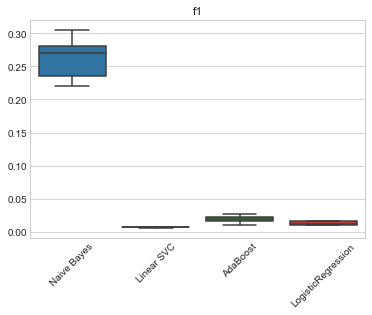

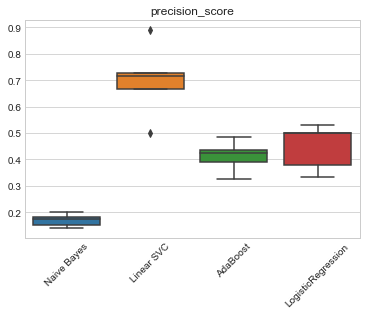

In [12]:
scoring()

In [17]:
def tune_param(model, param_grid, refit='f1', data=X_train, target=y_train, cv=5):
    estimator = {key: estimators[n] for n, key in enumerate(estimator_names)}[model]
    
    gcv = GridSearchCV(estimator, param_grid, scoring=_metrics, refit=refit, cv=cv)
    gcv.fit(data, target)
    
    print('best_score: ' + str(gcv.best_score_))
    print('best_params: ' + str(gcv.best_params_))

In [18]:
# Tuning Logistic Regression

param_grid = {"penalty": ['l1', 'l2'],
             "solver":['liblinear', 'saga']}

tune_param('LogisticRegression', param_grid)

/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: 

best_score: 0.04149494339375705
best_params: {'penalty': 'l2', 'solver': 'liblinear'}


In [21]:
# Tuning SVC

param_grid = {"C": [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]}

tune_param('Linear SVC', param_grid)

best_score: 0.007818885460916478
best_params: {'C': 0.2}


In [22]:
# Tuning AdaBoost

param_grid = {"n_estimators": [50, 75, 100, 125],
              "learning_rate": [1, 5, 10]}

tune_param('AdaBoost', param_grid)

best_score: 0.17920755980213113
best_params: {'learning_rate': 5, 'n_estimators': 50}


In [ ]:
# Tuning XGBoost

param_grid = {"n_estimators": [500, 1000, 1100, 1200],
              "max_depth": [5, 6, 7],
              "min_child_weight": [100, 200, 300, 400],
              "colsample_bytree": [0.5, 0.6, 0.7],
              "reg_alpha": [1, 1.1, 1.2, 1.3],
              "reg_lambda": [1, 1.1, 1.2, 1.3],
              "subsample": [0.8, 0.9, 1, 1.1],
              "eta": [0, 0.1, 0.2, 0.3],
              "seed": [42, 52, 62]
             }

tune_param('XGBoost', param_grid)

In [ ]:
# Tuning ExtraTrees

param_grid = {"n_estimators": [20, 21, 22, 23],
              "max_depth": [5, 6, 7],
              "random_state": [42, 52, 62]
             }

tune_param('ExtraTrees', param_grid)

In [ ]:
# Final models 

estimators_final = [
    ('AdaBoost', AdaBoostClassifier(learning_rate=5, n_estimators=50)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=22, max_depth=6,
                               random_state=42, n_jobs=-1, class_weight={1:5,0:1},
                               bootstrap=True)),
    ('XGBoost', XGBClassifier(max_depth=7, n_estimators=1100, min_child_weight=300, colsample_bytree=0.7, 
                              reg_alpha=1.3, reg_lambda=1.2, subsample=0.9, eta=0.3, seed=42))
]

In [ ]:
# Voting training

vc = VotingClassifier(estimators_final, voting='hard')
vc.fit(X_train, y_train)
y_pred = vc.predict(X_train)
print(classification_report(y_train, y_pred))

In [ ]:
# Model test

y_pred = vc.predict(X_test)
print(classification_report(y_test, y_pred))

### Save predict to csv

In [ ]:
df = pd.read_csv('S://Cup_IT_2022_Датасет_Data_Science.csv')    
y = df['is_in_club']
df = fill_missing(df)

In [ ]:
_, X_test, _, y_test = train_test_split(df, y, random_state=42, test_size=0.3, shuffle=False)

In [ ]:
bad_index = X_test.index[(X_test < 0).any(1)]
X_test = X_test.drop(index=bad_index).reset_index().drop(columns='index')
client_id = X_test['client_id']
X_test.drop(columns=['client_id','is_in_club'], inplace=True)

In [ ]:
X_test, y_test = prepare_data(X_test, y_test)

In [ ]:
y_pred = vc.predict(X_test)

In [ ]:
ans = pd.DataFrame()
ans['client_id'] = client_id
ans['is_in_club'] = y_pred

In [ ]:
ans.to_csv("predictions.csv",index=None)